# Radiative-Convective Equilibrium with CAM3 scheme

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import climlab
from climlab import constants as const

## Create a new custom process for RCE

In [38]:
class RCEmodel(climlab.TimeDependentProcess):
    def __init__(self,
                 num_lev=30,
                 num_lat=1,
                 lev=None,
                 lat=None,
                 water_depth=1.0,
                 albedo_sfc=0.299,
                 timestep=1. * const.seconds_per_day,
                 # lapse rate for convective adjustment, in K / km
                 adj_lapse_rate=6.5,
                 # insolation
                 Q=341.3,
                 CO2=380.,
                 **kwargs):
        # Check to see if an initial state is already provided
        #  If not, make one
        if 'state' not in kwargs:
            state = climlab.column_state(num_lev, num_lat, lev, lat, water_depth)
            kwargs.update({'state': state})
        super(RCEmodel, self).__init__(timestep=timestep, **kwargs)
        self.param['water_depth'] = water_depth
        self.param['albedo_sfc'] = albedo_sfc
        self.param['Q'] = Q
        
        self.param['adj_lapse_rate'] = adj_lapse_rate
        self.add_subprocess('convadj', 
            climlab.convection.convadj.ConvectiveAdjustment(state=self.state, **self.param))

        #  Initialize specific humidity
        h2o = climlab.radiation.water_vapor.ManabeWaterVapor(state=self.state, **self.param)
        self.add_subprocess('H2O', h2o)
        self.q = self.subprocess['H2O'].q
        rad = climlab.radiation.CAM3Radiation(state=self.state, 
                                              q=self.q, 
                                              CO2=CO2,
                                              insolation=Q,
                                              aldif=albedo_sfc,
                                              aldir=albedo_sfc,
                                              asdif=albedo_sfc,
                                              asdir=albedo_sfc)
        self.add_subprocess('rad', rad)

In [39]:
rce = RCEmodel()


 Building _cam3_radiation.so ... 

f2py -c -m _cam3_radiation --fcompiler=gnu95 --noopt -I/Users/Brian/climlab/src/radiation/cam3/src --f77flags="-DPLEV=30 -ffixed-line-length-132 -fdefault-real-8" --f90flags="-DPLEV=30 -fdefault-real-8 -fno-range-check -ffree-form" _cam3_radiation.pyf /Users/Brian/climlab/src/radiation/cam3/src/CliMT_dimensions.F90 /Users/Brian/climlab/src/radiation/cam3/src/ppgrid.F90 /Users/Brian/climlab/src/radiation/cam3/src/pmgrid.F90 /Users/Brian/climlab/src/radiation/cam3/src/prescribed_aerosols.F90 /Users/Brian/climlab/src/radiation/cam3/src/quicksort.F90 /Users/Brian/climlab/src/radiation/cam3/src/abortutils.F90 /Users/Brian/climlab/src/radiation/cam3/src/shr_kind_mod.F90 /Users/Brian/climlab/src/radiation/cam3/src/absems.F90 /Users/Brian/climlab/src/radiation/cam3/src/wv_saturation.F90 /Users/Brian/climlab/src/radiation/cam3/src/aer_optics.F90 /Users/Brian/climlab/src/radiation/cam3/src/cmparray_mod.F90 /Users/Brian/climlab/src/radiation/cam3/src/shr_const_

In [40]:
rce.state

{'Tatm': Field([ 200.        ,  202.68965517,  205.37931034,  208.06896552,
         210.75862069,  213.44827586,  216.13793103,  218.82758621,
         221.51724138,  224.20689655,  226.89655172,  229.5862069 ,
         232.27586207,  234.96551724,  237.65517241,  240.34482759,
         243.03448276,  245.72413793,  248.4137931 ,  251.10344828,
         253.79310345,  256.48275862,  259.17241379,  261.86206897,
         264.55172414,  267.24137931,  269.93103448,  272.62068966,
         275.31034483,  278.        ]), 'Ts': Field([ 288.])}

In [41]:
rce.compute()

In [42]:
rce.step_forward()

In [43]:
rce.state

{'Tatm': Field([ 129.7658189 ,  159.94981812,  176.2845473 ,  187.94499292,
         197.15472483,  204.83154834,  211.44985204,  217.28897115,
         222.5281989 ,  227.28992935,  231.66167863,  235.70833058,
         239.47940899,  243.01362751,  246.34186007,  249.48914963,
         252.47610797,  255.3199161 ,  258.03505554,  260.63385307,
         263.1268937 ,  265.52333847,  267.83117241,  270.05740027,
         272.20820292,  274.28906351,  276.3048701 ,  278.26000004,
         280.15838969,  282.00359262]), 'Ts': Field([ 282.90726705])}

In [44]:
rce.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 1.00207478763 years.


In [45]:
rce.state

{'Tatm': Field([ 128.88429627,  158.86325014,  175.08701455,  186.66824866,
         195.81541719,  203.44009066,  210.01343503,  215.81288794,
         221.01652468,  225.74590783,  230.08795902,  234.10712134,
         237.85258214,  241.36279207,  244.66841534,  247.7943248 ,
         250.76099219,  253.58548182,  256.28217683,  258.86332025,
         261.33942521,  263.7195905 ,  266.01174691,  268.2228516 ,
         270.35904346,  272.42576839,  274.42788124,  276.36972963,
         278.25522318,  280.08789131]), 'Ts': Field([ 280.98542692])}

In [46]:
rce.subprocess.rad.aldif

Field([ 0.299])

In [47]:
rce.subprocess.rad.Output['LwToa'] + rce.subprocess.rad.Output['SwToa']

array([[-0.01121003]])

In [48]:
rce.subprocess.rad.q

Field([  5.00000000e-06,   5.00000000e-06,   5.00000000e-06,
         5.00000000e-06,   5.00000000e-06,   5.00000000e-06,
         5.58222721e-06,   1.18961333e-05,   2.25302701e-05,
         3.90592555e-05,   6.32310320e-05,   9.69338092e-05,
         1.42166323e-04,   2.01011739e-04,   2.75615119e-04,
         3.68164177e-04,   4.80872975e-04,   6.15968198e-04,
         7.75677660e-04,   9.62220737e-04,   1.17780043e-03,
         1.42459684e-03,   1.70476183e-03,   2.02041465e-03,
         2.37363851e-03,   2.76647781e-03,   3.20093597e-03,
         3.67897383e-03,   4.20250844e-03,   4.77341227e-03])

In [49]:
rce.subprocess.rad.CO2 = 600.

In [50]:
rce.state

{'Tatm': Field([ 128.88429627,  158.86325014,  175.08701455,  186.66824866,
         195.81541719,  203.44009066,  210.01343503,  215.81288794,
         221.01652468,  225.74590783,  230.08795902,  234.10712134,
         237.85258214,  241.36279207,  244.66841534,  247.7943248 ,
         250.76099219,  253.58548182,  256.28217683,  258.86332025,
         261.33942521,  263.7195905 ,  266.01174691,  268.2228516 ,
         270.35904346,  272.42576839,  274.42788124,  276.36972963,
         278.25522318,  280.08789131]), 'Ts': Field([ 280.98542692])}

In [51]:
rce.integrate_years()

Integrating for 365 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 2.00141166601 years.


In [52]:
rce.state

{'Tatm': Field([ 129.40938112,  159.51047162,  175.80033294,  187.42874991,
         196.61318474,  204.26892173,  210.86904643,  216.69212677,
         221.91696354,  226.66561457,  231.02535563,  235.06089233,
         238.82161243,  242.34612324,  245.66521388,  248.80385854,
         251.78261237,  254.6186092 ,  257.32629075,  259.91794996,
         262.40414276,  264.79400504,  267.09549987,  269.31561278,
         271.46050766,  273.53565258,  275.54592221,  277.49568184,
         279.38885704,  281.22899161]), 'Ts': Field([ 282.13018384])}

In [53]:
rce.subprocess.rad.Output['SwToa'] + rce.subprocess.rad.Output['LwToa']

array([[ 0.00689926]])

In [54]:
print rce

climlab Process of type <class '__main__.RCEmodel'>. 
State variables and domain shapes: 
  Tatm: (30,) 
  Ts: (1,) 
The subprocess tree: 
top: <class '__main__.RCEmodel'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   rad: <class 'climlab.radiation.cam3rad.CAM3Radiation'>
   convadj: <class 'climlab.convection.convadj.ConvectiveAdjustment'>



## A simple, pure dry radiative equilibrium case

In [2]:
state = climlab.column_state(num_lev=30, num_lat=1, water_depth=5.)

In [3]:
# with default albedo
rce2 = climlab.radiation.CAM3Radiation(state=state)


 Building _cam3_radiation.so ... 

f2py -c -m _cam3_radiation --fcompiler=gnu95 --noopt -I/Users/br546577/code/climlab/src/radiation/cam3/src --f77flags="-DPLEV=30 -ffixed-line-length-132 -fdefault-real-8" --f90flags="-DPLEV=30 -fdefault-real-8 -fno-range-check -ffree-form" _cam3_radiation.pyf /Users/br546577/code/climlab/src/radiation/cam3/src/CliMT_dimensions.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/ppgrid.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/pmgrid.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/prescribed_aerosols.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/quicksort.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/abortutils.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/shr_kind_mod.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/absems.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/wv_saturation.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/aer_optics.F90 /Users/br546577/code/climla

In [4]:
rce2.state

{'Tatm': Field([ 200.        ,  202.68965517,  205.37931034,  208.06896552,
         210.75862069,  213.44827586,  216.13793103,  218.82758621,
         221.51724138,  224.20689655,  226.89655172,  229.5862069 ,
         232.27586207,  234.96551724,  237.65517241,  240.34482759,
         243.03448276,  245.72413793,  248.4137931 ,  251.10344828,
         253.79310345,  256.48275862,  259.17241379,  261.86206897,
         264.55172414,  267.24137931,  269.93103448,  272.62068966,
         275.31034483,  278.        ]), 'Ts': Field([ 288.])}

In [5]:
rce2.integrate_years()

Integrating for 365 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 0.999336878378 years.


In [6]:
rce2.state

{'Tatm': Field([ 154.08186359,  168.59844694,  176.95105684,  183.327807  ,
         188.75950868,  193.47837045,  197.58119896,  201.42638195,
         204.99693988,  208.31491744,  211.32744024,  214.22958184,
         217.08250696,  219.86097677,  222.54916093,  225.16586771,
         227.72185085,  230.21487975,  232.59737076,  234.99857746,
         237.4862417 ,  240.03301152,  242.64256201,  245.35207319,
         248.20248741,  251.25763415,  254.64384881,  258.38005822,
         261.21190829,  265.58906909]), 'Ts': Field([ 281.22526044])}

In [7]:
#  with altered surface albedo
albedo_sfc = 0.3
rce_alb = climlab.radiation.CAM3Radiation(state=state,
                                       aldif=albedo_sfc, aldir=albedo_sfc, asdif=albedo_sfc, asdir=albedo_sfc)


 Building _cam3_radiation.so ... 

f2py -c -m _cam3_radiation --fcompiler=gnu95 --noopt -I/Users/br546577/code/climlab/src/radiation/cam3/src --f77flags="-DPLEV=30 -ffixed-line-length-132 -fdefault-real-8" --f90flags="-DPLEV=30 -fdefault-real-8 -fno-range-check -ffree-form" _cam3_radiation.pyf /Users/br546577/code/climlab/src/radiation/cam3/src/CliMT_dimensions.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/ppgrid.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/pmgrid.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/prescribed_aerosols.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/quicksort.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/abortutils.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/shr_kind_mod.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/absems.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/wv_saturation.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/aer_optics.F90 /Users/br546577/code/climla

In [8]:
rce_alb.do_sw = 0

In [9]:
rce_alb.integrate_years()

Integrating for 365 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 0.999336878378 years.


In [10]:
rce_alb.state

{'Tatm': Field([ 130.92148914,  149.33900895,  158.45390408,  165.14353214,
         170.79978526,  175.7250907 ,  179.98562859,  183.99626466,
         187.73697884,  191.21476862,  194.36696314,  197.39517434,
         200.37605544,  203.28175455,  206.08460742,  208.800816  ,
         211.44959214,  214.0424128 ,  216.52439877,  219.01780331,
         221.58434449,  224.19759859,  226.86172175,  229.62100296,
         232.51364688,  235.60618182,  239.02237992,  242.77053466,
         245.57541676,  249.89740098]), 'Ts': Field([ 265.34220042])}

In [38]:
rce_alb.Output['SwToa']

array([[ 238.91]])

#  Simpler coupled RCE model setup

By initializing each component with the same state object, the components are already effectively coupled. They all act to modify the same state object.

No extra coupling code is necessary.

In [2]:
# initial state (temperatures)
state = climlab.column_state(num_lev=30, num_lat=1, water_depth=5.)
#  Create a parent process
rce = climlab.TimeDependentProcess(state=state)
## Create individual physical process models:
#  fixed relative humidity
h2o = climlab.radiation.water_vapor.ManabeWaterVapor(state=state)
#  Hard convective adjustment
convadj = climlab.convection.convadj.ConvectiveAdjustment(state=state, adj_lapse_rate=6.5)
# CAM3 radiation with default parameters and interactive water vapor
rad = climlab.radiation.CAM3Radiation(state=state, q=h2o.q)

# Couple the models
rce.add_subprocess('Radiation', rad)
rce.add_subprocess('ConvectiveAdjustment', convadj)
rce.add_subprocess('H2O', h2o)

#  Make diagnostic water vapor field easy to access
rce.q = rce.subprocess.H2O.q


 Building _cam3_radiation.so ... 

f2py -c -m _cam3_radiation --fcompiler=gnu95 --noopt -I/Users/br546577/code/climlab/src/radiation/cam3/src --f77flags="-DPLEV=30 -ffixed-line-length-132 -fdefault-real-8" --f90flags="-DPLEV=30 -fdefault-real-8 -fno-range-check -ffree-form" _cam3_radiation.pyf /Users/br546577/code/climlab/src/radiation/cam3/src/CliMT_dimensions.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/ppgrid.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/pmgrid.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/prescribed_aerosols.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/quicksort.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/abortutils.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/shr_kind_mod.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/absems.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/wv_saturation.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/aer_optics.F90 /Users/br546577/code/climla

In [3]:
print rce

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Tatm: (30,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   ConvectiveAdjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   Radiation: <class 'climlab.radiation.cam3rad.CAM3Radiation'>



In [4]:
rce.state

{'Tatm': Field([ 200.        ,  202.68965517,  205.37931034,  208.06896552,
         210.75862069,  213.44827586,  216.13793103,  218.82758621,
         221.51724138,  224.20689655,  226.89655172,  229.5862069 ,
         232.27586207,  234.96551724,  237.65517241,  240.34482759,
         243.03448276,  245.72413793,  248.4137931 ,  251.10344828,
         253.79310345,  256.48275862,  259.17241379,  261.86206897,
         264.55172414,  267.24137931,  269.93103448,  272.62068966,
         275.31034483,  278.        ]), 'Ts': Field([ 288.])}

In [5]:
rce.integrate_years(5)

Integrating for 1826 steps, 1826.211 days, or 5 years.
Total elapsed time is 4.99942230115 years.


In [6]:
rce.state

{'Tatm': Field([ 141.47026784,  170.77322533,  188.2132851 ,  200.66276413,
         210.49569574,  218.69199084,  225.75813873,  231.99237653,
         237.58612983,  242.67007475,  247.33764945,  251.65812831,
         255.68438623,  259.45775655,  263.01120234,  266.37146118,
         269.56053957,  272.59678114,  275.49564733,  278.27029903,
         280.93203753,  283.49064378,  285.95464311,  288.33151428,
         290.62785641,  292.84952367,  295.0017349 ,  297.08916362,
         299.11601259,  301.08607583]), 'Ts': Field([ 302.05089966])}

In [7]:
rce.q

Field([  5.00000000e-06,   5.00000000e-06,   5.00000000e-06,
         5.00000000e-06,   5.67996182e-06,   1.63802087e-05,
         3.78954938e-05,   7.55114592e-05,   1.35165082e-04,
         2.23251578e-04,   3.46465636e-04,   5.11674666e-04,
         7.25819408e-04,   9.95837010e-04,   1.32860215e-03,
         1.73088254e-03,   2.20930572e-03,   2.77033484e-03,
         3.42025138e-03,   4.16514339e-03,   5.01089803e-03,
         5.96319742e-03,   7.02751712e-03,   8.20912657e-03,
         9.51309114e-03,   1.09442753e-02,   1.25073465e-02,
         1.42067803e-02,   1.60468650e-02,   1.80317076e-02])

In [8]:
rce.subprocess.Radiation.input

{'CFC11': 1e-09,
 'CFC12': 1e-09,
 'CH4': 1e-09,
 'CO2': 380.0,
 'N2O': 1e-09,
 'O3': Field([  1.00000000e-09,   1.00000000e-09,   1.00000000e-09,
          1.00000000e-09,   1.00000000e-09,   1.00000000e-09,
          1.00000000e-09,   1.00000000e-09,   1.00000000e-09,
          1.00000000e-09,   1.00000000e-09,   1.00000000e-09,
          1.00000000e-09,   1.00000000e-09,   1.00000000e-09,
          1.00000000e-09,   1.00000000e-09,   1.00000000e-09,
          1.00000000e-09,   1.00000000e-09,   1.00000000e-09,
          1.00000000e-09,   1.00000000e-09,   1.00000000e-09,
          1.00000000e-09,   1.00000000e-09,   1.00000000e-09,
          1.00000000e-09,   1.00000000e-09,   1.00000000e-09]),
 'aldif': Field([ 0.07]),
 'aldir': Field([ 0.07]),
 'asdif': Field([ 0.07]),
 'asdir': Field([ 0.07]),
 'ciwp': Field([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]),
 'cld

# Latitudinally, seasonally varying RCE

In [9]:
# initial state (temperatures)
state = climlab.column_state(num_lev=30, num_lat=30, water_depth=10.)
#  Create a parent process
rcelat = climlab.TimeDependentProcess(state=state)
## Create individual physical process models:
#  seasonal insolation
insol = climlab.radiation.insolation.DailyInsolation(domains=rcelat.Ts.domain)
#  fixed relative humidity
h2o = climlab.radiation.water_vapor.ManabeWaterVapor(state=state)
#  Hard convective adjustment
convadj = climlab.convection.convadj.ConvectiveAdjustment(state=state, adj_lapse_rate=6.5)
# CAM3 radiation with default parameters and interactive water vapor
rad = climlab.radiation.CAM3Radiation(state=state, q=h2o.q, insolation=insol.insolation)

# Couple the models
rcelat.add_subprocess('Insolation', insol)
rcelat.add_subprocess('Radiation', rad)
rcelat.add_subprocess('ConvectiveAdjustment', convadj)
rcelat.add_subprocess('H2O', h2o)

#  Make diagnostic water vapor field easy to access
rcelat.q = rcelat.subprocess.H2O.q


 Building _cam3_radiation.so ... 

f2py -c -m _cam3_radiation --fcompiler=gnu95 --noopt -I/Users/br546577/code/climlab/src/radiation/cam3/src --f77flags="-DPLEV=30 -ffixed-line-length-132 -fdefault-real-8" --f90flags="-DPLEV=30 -fdefault-real-8 -fno-range-check -ffree-form" _cam3_radiation.pyf /Users/br546577/code/climlab/src/radiation/cam3/src/CliMT_dimensions.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/ppgrid.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/pmgrid.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/prescribed_aerosols.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/quicksort.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/abortutils.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/shr_kind_mod.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/absems.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/wv_saturation.F90 /Users/br546577/code/climlab/src/radiation/cam3/src/aer_optics.F90 /Users/br546577/code/climla

In [10]:
rcelat.step_forward()

In [11]:
rcelat.integrate_years(5)

Integrating for 1826 steps, 1826.211 days, or 5 years.
Total elapsed time is 5.0021602104 years.


In [12]:
rcelat.integrate_years(1)

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 6.00149708878 years.


In [13]:
def plot_temp_section(model, timeave=True):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if timeave:
        field = model.timeave['Tatm'].transpose()
    else:
        field = model.Tatm.transpose()
    cax = ax.contourf(model.lat, model.lev, field)
    ax.invert_yaxis()
    ax.set_xlim(-90,90)
    ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])
    fig.colorbar(cax)

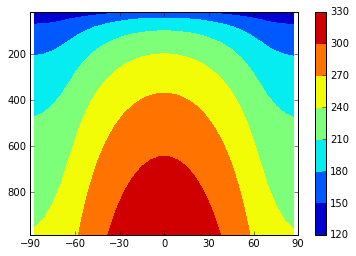

In [14]:
plot_temp_section(rcelat)